### Task 1: Import Libraries

In [1]:
from random import random
import matplotlib.pyplot as plt
import os
#import PIL
import tensorflow as tf
import time
import scipy

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, GlobalAveragePooling2D#, Input,Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential#, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau#, EarlyStopping
from tensorflow.keras.utils import plot_model
#from sklearn.model_selection import KFold, StratifiedKFold

from IPython.display import clear_output
from matplotlib import get_backend

#from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.1.0


### Task 2: Plot Sample Images

In [2]:
for expression in os.listdir("daisee/train/"):
    if not expression.startswith('.'):  
        print(str(len(os.listdir("daisee/train/" + expression))) + " " + expression + " images")

2401 normally_engaged images
215 not_engaged images
2429 very_engaged images


### Task 3: Generate Training and Validation Batches

In [3]:
img_size = 48 #set image 
batch_size = 50 #can change to see if the it gives better result

#datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train = ImageDataGenerator(
                rescale=1./255,
                rotation_range=30,
                shear_range=0.3,
                zoom_range=0.3,
                horizontal_flip=True)
datagen_validation = ImageDataGenerator(horizontal_flip=False)

#load images from training directory
train_generator = datagen_train.flow_from_directory("daisee/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_train.flow_from_directory("daisee/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

test_generator = datagen_train.flow_from_directory("daisee/evaluation/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 5045 images belonging to 3 classes.
Found 1525 images belonging to 3 classes.
Found 1459 images belonging to 3 classes.


###  Task 4: Training and Evcaluation: 1. Murshed, 2. VGG, 3. Modif

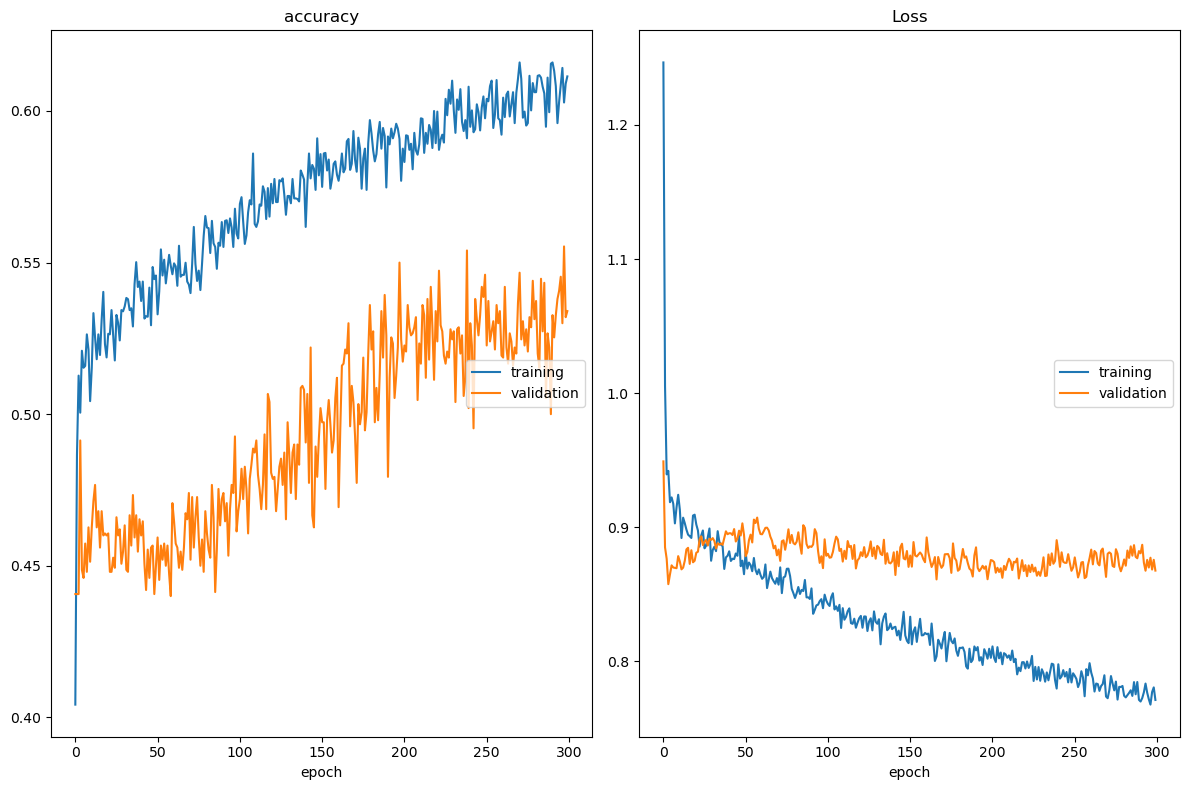

accuracy
	training         	 (min:    0.404, max:    0.616, cur:    0.611)
	validation       	 (min:    0.440, max:    0.555, cur:    0.534)
Loss
	training         	 (min:    0.768, max:    1.247, cur:    0.771)
	validation       	 (min:    0.857, max:    0.949, cur:    0.868)

Epoch 00300: saving model to weights/weights_murshed2019.h5
100/100 [==============================] - 6s 57ms/step - loss: 0.7709 - accuracy: 0.6114 - val_loss: 0.8676 - val_accuracy: 0.5340


In [11]:
## Mursheed
# Initialising the CNN
model = Sequential()

model.add(Conv2D(192,(3,3), padding='same', input_shape=(img_size, img_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(192,(1,1)))
model.add(Activation('relu'))

model.add(Conv2D(192,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(96,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(96,(1,1)))
model.add(Conv2D(96,(1,1)))

model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model.add(Dropout(0.3))

model.add(Conv2D(32,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Fully connected layer 2nd layer
model.add(Dense(512, name = 'convy'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

'''
model.add(Conv2D(3,(1,1), name = 'convy'))
model.add(GlobalAveragePooling2D())
'''
model.add(Dense(3, activation='softmax'))

model.get_layer('convy').kernel_regularizer = regularizers.l2(0.0001) #0.0001
opt = Adam(lr=0.0001)#0.0005
#opt = SGD(lr=0.01, decay=0, momentum=0.01)#decay=1e-6, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

tic = time.time()

# ################ Train and Evaluate Model ###############################

epochs = 300
steps_per_epoch = train_generator.n//train_generator.batch_size #number of samples/batch size
#n number of samples in train_generator // (floor division) by batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

#make checkpoint and save it when it reach the best accuracy during the training
checkpoint = ModelCheckpoint("weights/weights_murshed2019.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)#make check point during training and save the weight

#learning rate schedule: reduce learning rate 0.1 every 2 epochs 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
#early stopping
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#use livelossplot to monitor the accuracy during the training 
#callbacks = [PlotLossesCallback(), checkpoint, reduce_lr, early_stopping] 
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr] 

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# print duration
toc = time.time()

tictoc = 1000*(toc-tic)
tictocC = str(round(tictoc,3))

plt.savefig('models/Accuracy_murshed2019.png')
 
  
# ### Represent Model as JSON String

model_json = model.to_json()
with open("models/model_murshed2019.json", "w") as json_file:
    json_file.write(model_json)

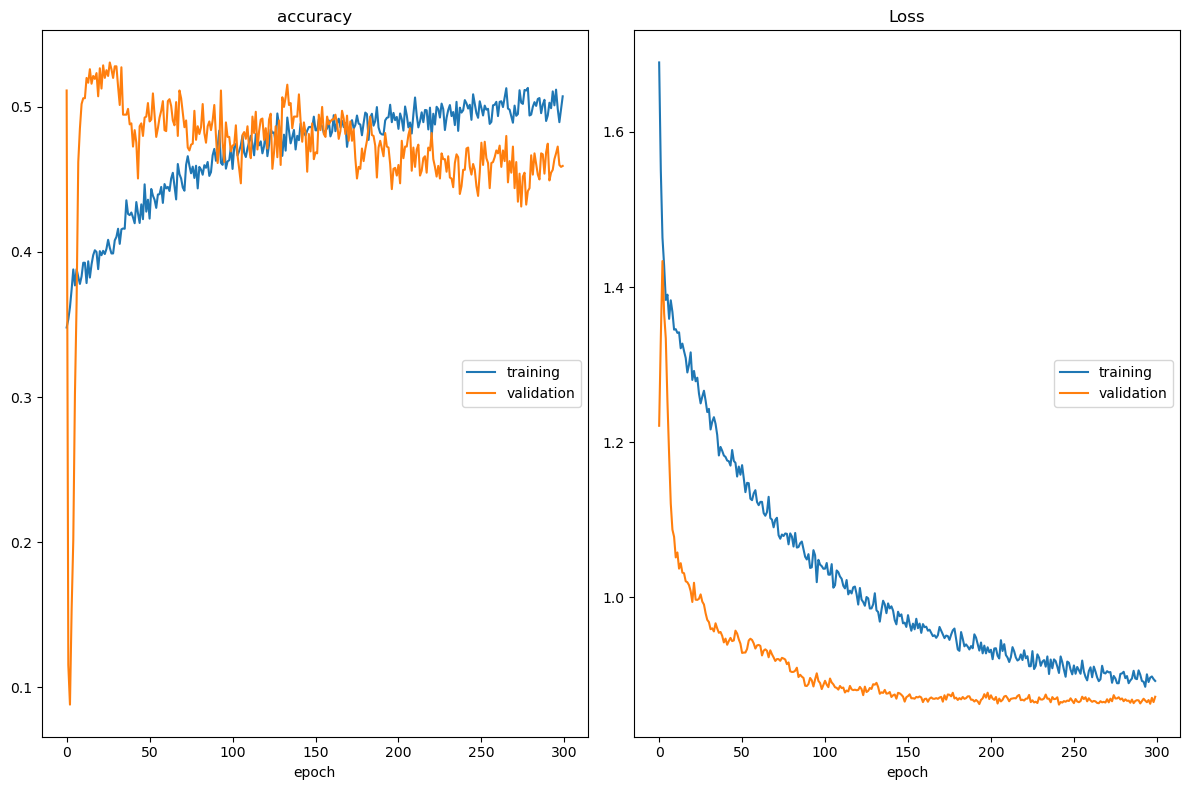

accuracy
	training         	 (min:    0.348, max:    0.513, cur:    0.507)
	validation       	 (min:    0.088, max:    0.531, cur:    0.459)
Loss
	training         	 (min:    0.885, max:    1.690, cur:    0.892)
	validation       	 (min:    0.862, max:    1.434, cur:    0.872)

Epoch 00300: saving model to weights/weights_4convBlocks.h5
100/100 [==============================] - 3s 28ms/step - loss: 0.8922 - accuracy: 0.5073 - val_loss: 0.8720 - val_accuracy: 0.4593
Training and Evaluation:842929.449 ms


In [9]:
## Modified

# Initialising the CNN
model = Sequential()

## 4 conv net layers, 3 dense layers (2 fully connected, 1 softmax) 
# 1 - Convolution
model.add(Conv2D(32,(3,3), input_shape=(img_size, img_size,1))) #64,(3,3), padding='same', input_shape=(img_size, img_size,1)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #downsampling/ shrink the height and width dimension by factor of 2  
model.add(Dropout(0.2))#0.25

# 2nd Convolution layer
model.add(Conv2D(64,(3,3) ))#128,(5,5), padding='same')
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd Convolution layer
model.add(Conv2D(128,(3,3)))#(512,(3,3), padding='same')
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 4th Convolution layer
model.add(Conv2D(256,(3,3)))#(512,(3,3), padding='same')
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(64))#(256)
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

'''
# Fully connected layer 2st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
'''
# Fully connected layer 3nd layer
model.add(Dense(64, name = 'convy'))#512, name = 'convy')
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
'''
model.add(Conv2D(3,(1,1), name = 'convy'))
model.add(GlobalAveragePooling2D())
'''
model.add(Dense(3, activation='softmax'))

model.get_layer('convy').kernel_regularizer = regularizers.l2(0.0001) #0.0001
opt = Adam(lr=0.0001)#0.0005
#opt=SGD(lr=0.005, momentum = 0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ### Visualize Model Architecture

plot_model(model, to_file='models/model_4convBlocks.png', show_shapes=True, show_layer_names=True)
#Image('model_serv.png',width=400, height=200)

tic = time.time()

# ### Train and Evaluate Model
epochs =300
steps_per_epoch = train_generator.n//train_generator.batch_size #number of samples/batch size

validation_steps = validation_generator.n//validation_generator.batch_size #n number of samples in train_generator // (floor division) by batch_size

#make checkpoint and save it when it reach the best accuracy during the training
checkpoint = ModelCheckpoint("weights/weights_4convBlocks.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)#make check point during training and save the weight

#learning rate schedule: reduce learning rate 0.1 every 2 epochs 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#use livelossplot to monitor the accuracy during the training 

#callbacks = [PlotLossesCallback(), checkpoint, reduce_lr, early_stopping] 
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr] 

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# print duration
toc = time.time()

tictoc = 1000*(toc-tic)
tictocC = str(round(tictoc,3))

print("Training and Evaluation:" + tictocC+" ms")

plt.savefig('models/Accuracy_4convBlocks.png')
 
  
# ### Represent Model as JSON String

model_json = model.to_json()
with open("models/model_4convBlocks.json", "w") as json_file:
    json_file.write(model_json)


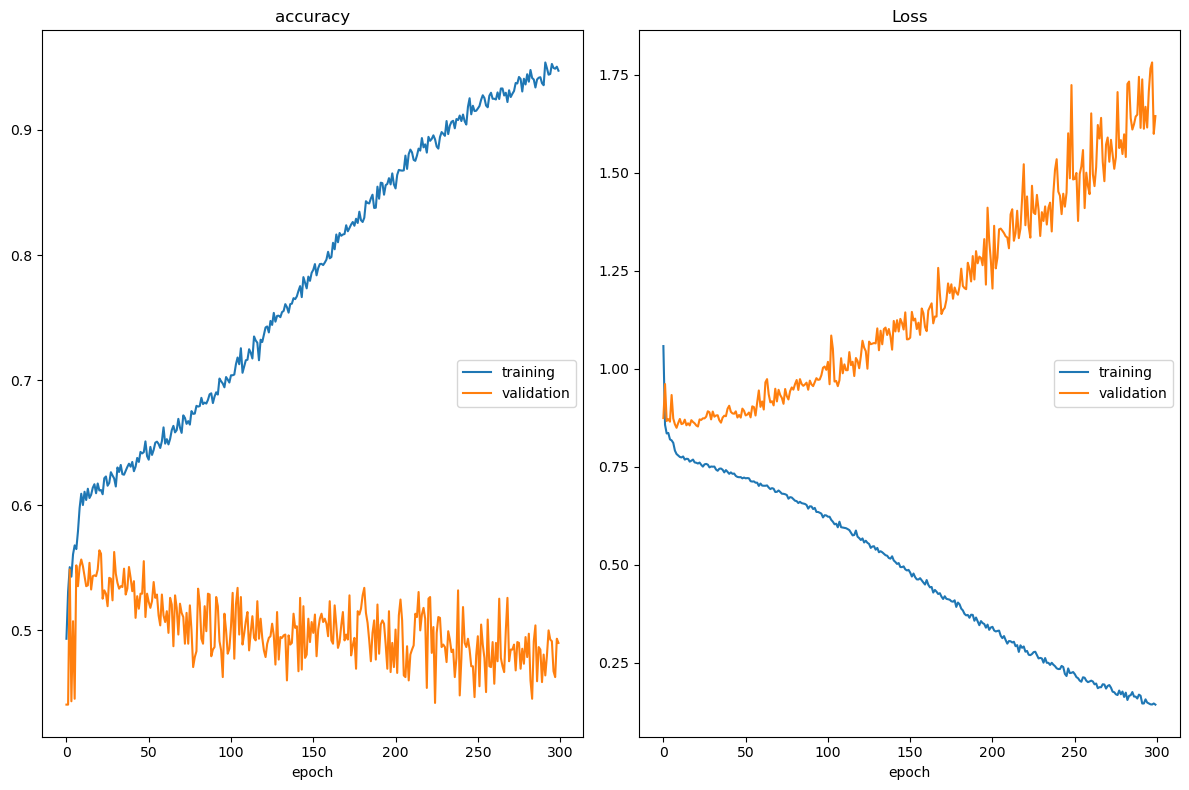

accuracy
	training         	 (min:    0.493, max:    0.954, cur:    0.947)
	validation       	 (min:    0.441, max:    0.564, cur:    0.490)
Loss
	training         	 (min:    0.144, max:    1.058, cur:    0.144)
	validation       	 (min:    0.849, max:    1.781, cur:    1.644)

Epoch 00300: saving model to weights/weights_vggB.h5
100/100 [==============================] - 4s 35ms/step - loss: 0.1435 - accuracy: 0.9473 - val_loss: 1.6444 - val_accuracy: 0.4900
Training and Evaluation:1046581.525 ms


In [8]:
## VGG

# Initialising the CNN
model = Sequential()

## 4 conv net layers, 3 dense layers (2 fully connected, 1 softmax) 
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(img_size, img_size,1)))
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #downsampling/ shrink the height and width dimension by factor of 2  
#model.add(Dropout(0.5))

# 2nd Convolution layer
model.add(Conv2D(128,(3,3), padding='same'))
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

# 3rd Convolution layer
model.add(Conv2D(256,(3,3), padding='same'))
model.add(Conv2D(256,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

# 5th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))


# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(4096))#256
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(4096))#4096
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(1000, name = 'convy'))#512
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.25))
'''
model.add(Conv2D(3,(1,1), name = 'convy'))
model.add(GlobalAveragePooling2D())
'''

model.add(Dense(3, activation='softmax'))

model.get_layer('convy').kernel_regularizer = regularizers.l1(0.0001) #0.0001
opt = Adam(lr=0.0001)
#opt=SGD(lr=0.02, momentum = 0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ### Visualize Model Architecture

plot_model(model, to_file='models/model_vggB.png', show_shapes=True, show_layer_names=True)
#Image('model_serv.png',width=400, height=200)

tic = time.time()

##################### Training and Evaluation ###############################

epochs = 300
steps_per_epoch = train_generator.n//train_generator.batch_size #number of samples/batch size
#n number of samples in train_generator // (floor division) by batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

#make checkpoint and save it when it reach the best accuracy during the training
checkpoint = ModelCheckpoint("weights/weights_vggB.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)#make check point during training and save the weight

#learning rate schedule: reduce learning rate 0.1 every 2 epochs 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#use livelossplot to monitor the accuracy during the training 
#callbacks = [PlotLossesCallback(), checkpoint, reduce_lr, early_stopping]
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr] 

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# print duration
toc = time.time()

tictoc = 1000*(toc-tic)
tictocC = str(round(tictoc,3))

print("Training and Evaluation:" + tictocC+" ms")

plt.savefig('models/Accuracy_vggB.png')

## Export Models
model_json = model.to_json()
with open("models/modelsmodel_vggB.json", "w") as json_file:
    json_file.write(model_json)

### Export The Model